In [ ]:
from google.colab import drive
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot
import numpy
import pandas
import seaborn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pandas.set_option('display.max_columns', None)

In [ ]:
drive.mount('/content/drive')

df = pandas.read_csv('/content/drive/MyDrive/nba_mvp_1980_2024.csv', sep = ',', decimal = '.')
df.tail()

Mounted at /content/drive


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,First,Pts Won,Pts Max,Share,Rk,Overall
21713,Thaddeus Young,PF,35,PHO,10,0,8.9,1.1,2.1,0.524,0.0,0.1,0.000,1.1,2.0,0.550,0.524,0.1,0.3,0.333,1.7,1.1,2.8,0.7,0.5,0.2,0.4,1.1,2.3,2024,15.1,0.515,0.048,0.143,22.8,13.3,17.8,10.4,2.7,2.0,15.2,12.8,0.1,0.1,0.3,0.137,-1.5,0.6,-0.9,0.0,0,0,0,0.0,10,49-33
21714,Trae Young,PG,25,ATL,54,54,36.0,8.0,18.7,0.430,3.2,8.7,0.373,4.8,10.0,0.479,0.516,6.4,7.5,0.855,0.4,2.3,2.8,10.8,1.3,0.2,4.4,2.0,25.7,2024,20.3,0.585,0.465,0.404,1.2,7.3,4.2,45.1,1.8,0.5,16.5,30.5,4.0,0.6,4.6,0.114,4.9,-2.3,2.6,2.2,0,0,0,0.0,21,36-46
21715,Omer Yurtseven,C,25,UTA,48,12,11.4,2.1,3.8,0.538,0.1,0.5,0.208,2.0,3.3,0.588,0.552,0.4,0.6,0.679,1.5,2.8,4.3,0.6,0.2,0.4,0.8,1.1,4.6,2024,15.0,0.565,0.130,0.152,14.7,27.3,21.0,7.7,0.7,2.9,15.9,17.9,0.3,0.4,0.7,0.062,-1.6,-1.5,-3.0,-0.1,0,0,0,0.0,23,31-51
21716,Cody Zeller,C,31,NOP,43,0,7.4,0.6,1.4,0.419,0.0,0.1,0.333,0.6,1.4,0.424,0.427,0.5,0.9,0.605,1.1,1.5,2.6,0.9,0.2,0.1,0.4,1.0,1.8,2024,12.8,0.483,0.048,0.613,16.9,22.0,19.5,15.2,1.4,1.5,16.9,12.9,0.4,0.4,0.8,0.124,-2.9,0.3,-2.6,0.0,0,0,0,0.0,9,49-33
21717,Ivica Zubac,C,26,LAC,68,68,26.4,5.0,7.6,0.649,0.0,0.0,0.000,5.0,7.6,0.649,0.649,1.8,2.4,0.723,2.9,6.3,9.2,1.4,0.3,1.2,1.2,2.6,11.7,2024,19.3,0.671,0.000,0.320,12.8,26.2,19.7,7.5,0.6,4.2,11.8,16.4,4.5,2.3,6.8,0.182,0.8,0.0,0.8,1.3,0,0,0,0.0,5,51-31


In [ ]:
df['Wins'] = df.Overall.apply(lambda x: x.split('-')[0]).astype(int)
df['Losses'] = df.Overall.apply(lambda x: x.split('-')[1]).astype(int)
df['W/L%'] = df.Wins / (df.Wins + df.Losses)
df['GS%'] = df.GS / df.G
df['GP%'] = df.G / (df.Wins + df.Losses)
df['MVP Rank'] = numpy.where(df.Season <= 2023, df.groupby('Season')['Pts Won'].rank(ascending = False, method = 'dense'), 0.0)
df['Won MVP'] = numpy.where(df['MVP Rank'] == 1, 1, 0)
df.tail()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Season,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,First,Pts Won,Pts Max,Share,Rk,Overall,Wins,Losses,W/L%,GS%,GP%,MVP Rank,Won MVP
21713,Thaddeus Young,PF,35,PHO,10,0,8.9,1.1,2.1,0.524,0.0,0.1,0.000,1.1,2.0,0.550,0.524,0.1,0.3,0.333,1.7,1.1,2.8,0.7,0.5,0.2,0.4,1.1,2.3,2024,15.1,0.515,0.048,0.143,22.8,13.3,17.8,10.4,2.7,2.0,15.2,12.8,0.1,0.1,0.3,0.137,-1.5,0.6,-0.9,0.0,0,0,0,0.0,10,49-33,49,33,0.597561,0.00,0.121951,0.0,0
21714,Trae Young,PG,25,ATL,54,54,36.0,8.0,18.7,0.430,3.2,8.7,0.373,4.8,10.0,0.479,0.516,6.4,7.5,0.855,0.4,2.3,2.8,10.8,1.3,0.2,4.4,2.0,25.7,2024,20.3,0.585,0.465,0.404,1.2,7.3,4.2,45.1,1.8,0.5,16.5,30.5,4.0,0.6,4.6,0.114,4.9,-2.3,2.6,2.2,0,0,0,0.0,21,36-46,36,46,0.439024,1.00,0.658537,0.0,0
21715,Omer Yurtseven,C,25,UTA,48,12,11.4,2.1,3.8,0.538,0.1,0.5,0.208,2.0,3.3,0.588,0.552,0.4,0.6,0.679,1.5,2.8,4.3,0.6,0.2,0.4,0.8,1.1,4.6,2024,15.0,0.565,0.130,0.152,14.7,27.3,21.0,7.7,0.7,2.9,15.9,17.9,0.3,0.4,0.7,0.062,-1.6,-1.5,-3.0,-0.1,0,0,0,0.0,23,31-51,31,51,0.378049,0.25,0.585366,0.0,0
21716,Cody Zeller,C,31,NOP,43,0,7.4,0.6,1.4,0.419,0.0,0.1,0.333,0.6,1.4,0.424,0.427,0.5,0.9,0.605,1.1,1.5,2.6,0.9,0.2,0.1,0.4,1.0,1.8,2024,12.8,0.483,0.048,0.613,16.9,22.0,19.5,15.2,1.4,1.5,16.9,12.9,0.4,0.4,0.8,0.124,-2.9,0.3,-2.6,0.0,0,0,0,0.0,9,49-33,49,33,0.597561,0.00,0.524390,0.0,0
21717,Ivica Zubac,C,26,LAC,68,68,26.4,5.0,7.6,0.649,0.0,0.0,0.000,5.0,7.6,0.649,0.649,1.8,2.4,0.723,2.9,6.3,9.2,1.4,0.3,1.2,1.2,2.6,11.7,2024,19.3,0.671,0.000,0.320,12.8,26.2,19.7,7.5,0.6,4.2,11.8,16.4,4.5,2.3,6.8,0.182,0.8,0.0,0.8,1.3,0,0,0,0.0,5,51-31,51,31,0.621951,1.00,0.829268,0.0,0


In [ ]:
df_past = df[df.Season <= 2023]
df_current = df[df.Season == 2024]

In [ ]:
df_past = df_past[df_past['Pts Won'] > 0]

corr = df_past.corr(method = 'pearson', numeric_only = True)
won_mvp_corr = corr[['Won MVP']]
won_mvp_corr['Won MVP'].abs().sort_values()

ORB%        0.016025
Pts Max     0.017544
Age         0.023235
ORB         0.026176
3PAr        0.031059
GS%         0.032317
TOV%        0.035946
FTr         0.040257
Season      0.041427
3P%         0.041909
BLK%        0.043467
STL%        0.049126
3PA         0.052926
BLK         0.054543
3P          0.059465
STL         0.062990
GS          0.068066
G           0.080243
PF          0.087866
FT%         0.090086
TRB%        0.092160
MP          0.093709
FG%         0.096107
GP%         0.097133
AST         0.103808
DRB%        0.109934
TRB         0.111973
AST%        0.124048
2P%         0.126974
eFG%        0.130478
2PA         0.134942
TOV         0.140949
DRB         0.141800
FTA         0.164376
TS%         0.165867
FGA         0.170231
2P          0.176173
USG%        0.190456
FT          0.192270
DWS         0.206155
DBPM        0.215407
FG          0.218563
Rk          0.230861
PTS         0.232688
Wins        0.241259
Losses      0.254875
W/L%        0.264875
OBPM        0

In [ ]:
def plot_two_variables(df, title, var1, var1_order, var2, var2_order):
    matplotlib.pyplot.style.use('fivethirtyeight')
    fig, ax = matplotlib.pyplot.subplots()

    mvp = df[df['Won MVP'] == 1]
    not_mvp = df[df['Won MVP'] != 1]

    ax.scatter(mvp[var1], mvp[var2], label = 'MVP', marker = '^', s = 100)
    ax.scatter(not_mvp[var1], not_mvp[var2], label = 'Not MVP', alpha = 0.2)
    ax.legend(loc = 'best', prop = {'size': 12})
    ax.set_xlim(ax.get_xlim()[::var1_order])
    ax.set_ylim(ax.get_ylim()[::var2_order])
    ax.set_xlabel(var1, fontsize = 16)
    ax.set_ylabel(var2, fontsize = 16)

    fig.suptitle(title, weight = 'bold', size = 20)
    fig.text(x = -0.02, y = -0.08, s = '____________________________________________________', fontsize = 16, color = 'grey', horizontalalignment = 'left', alpha = 0.2)
    fig.text(x = -0.02, y = -0.16, s = 'https://crisbraatz.github.io', fontsize = 16, color = 'grey', horizontalalignment = 'left')

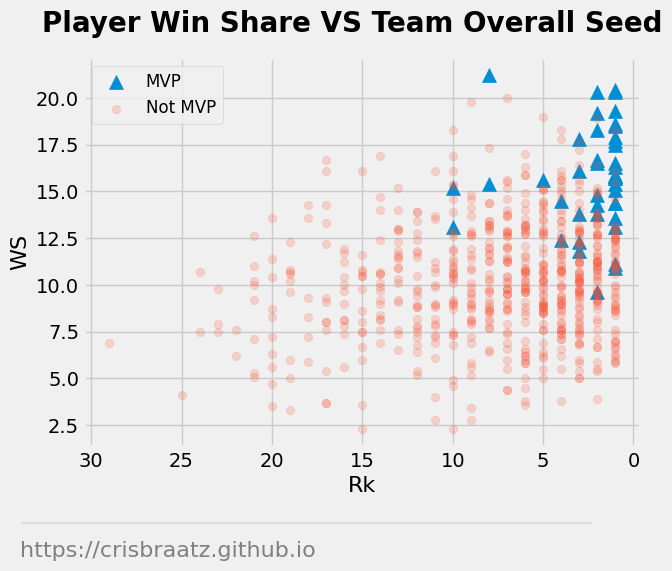

In [ ]:
plot_two_variables(df_past, 'Player Win Share VS Team Overall Seed', 'Rk', -1, 'WS', 1)

In [ ]:
df_past[(df_past['Won MVP'] == 1) & (df_past['Rk'] > 5)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
862,Moses Malone,HOU,42.0,31.1,14.7,1.8,0.9,1.5,0.519,0.000,0.762,15.4,0.218,1982,8,46-36,0.560976
2905,Michael Jordan,CHI,40.4,35.0,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988,8,50-32,0.609756
17260,Russell Westbrook,OKC,34.6,31.6,10.7,10.4,1.6,0.4,0.425,0.343,0.845,13.1,0.224,2017,10,47-35,0.573171
20080,Nikola Jokić,DEN,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296,2022,10,48-34,0.585366


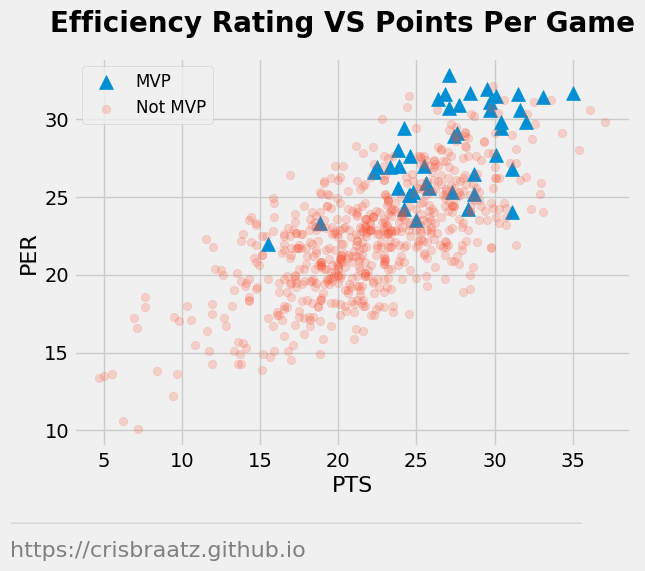

In [ ]:
plot_two_variables(df_past, 'Efficiency Rating VS Points Per Game', 'PTS', 1, 'PER', 1)

In [ ]:
df_past[(df_past['Won MVP'] == 1) & (df_past['PTS'] <= 20)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
10781,Steve Nash,PHO,34.3,15.5,3.3,11.5,1.0,0.1,0.502,0.431,0.887,10.9,0.203,2005,1,62-20,0.756098
11294,Steve Nash,PHO,35.4,18.8,4.2,10.5,0.8,0.2,0.512,0.439,0.921,12.4,0.212,2006,4,54-28,0.658537


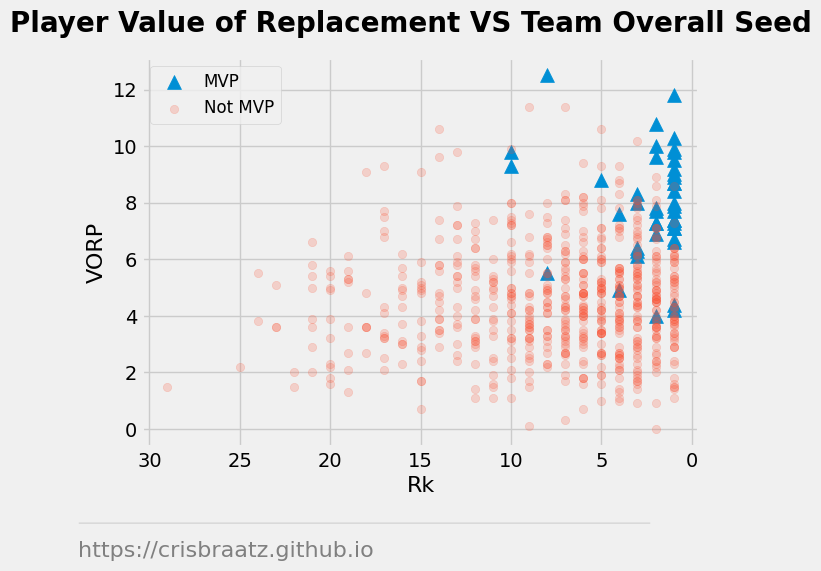

In [ ]:
plot_two_variables(df_past, 'Player Value of Replacement VS Team Overall Seed', 'Rk', -1, 'VORP', 1)

In [ ]:
def build_features(df_train, df_test):
    mms = MinMaxScaler()

    x_train_mms = mms.fit_transform(df_train[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
                                              '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
                                              'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr',
                                              'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
                                              'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Rk', 'Wins', 'Losses', 'W/L%', 'GS%', 'GP%']])
    x_test_mms = mms.transform(df_test[['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
                                        '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
                                        'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', '3PAr', 'FTr',
                                        'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS',
                                        'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Rk', 'Wins', 'Losses', 'W/L%', 'GS%', 'GP%']])

    x_train = numpy.hstack([x_train_mms])
    x_test = numpy.hstack([x_test_mms])
    y_train = df_train['Won MVP'].values.reshape(-1, 1)
    y_test = df_test['Won MVP'].values.reshape(-1, 1)

    return x_train, y_train, x_test, y_test

In [ ]:
model = LogisticRegression(solver = 'liblinear')

In [ ]:
df_past_predicted = []
results_matrix = numpy.zeros(shape = (1, 2023 - 1980, 4, 2))
for season in range(1980, 2024):
    fold = season - 1980 - 1
    df_train = df_past[df_past.Season != season]
    df_test = df_past[df_past.Season == season]
    x_train, y_train, x_test, y_test = build_features(df_train, df_test)
    model.fit(x_train, y_train)

    df_train_rank = df_train.copy()
    df_train_rank['MVP Odds'] = model.predict_proba(x_train)[:, 1]
    df_train_rank['Predicted MVP Rank'] = df_train_rank.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')
    df_train_rank['Predicted MVP Winner'] = df_train_rank['Predicted MVP Rank']
    df_train_rank['Predicted MVP Winner'].loc[df_train_rank['Predicted MVP Winner'] != 1] = 0

    df_train_rank_won_mvp = df_train_rank['Won MVP']
    df_train_rank_predicted_mvp_winner = df_train_rank['Predicted MVP Winner']

    results_matrix[0, fold, 0, 0] = metrics.accuracy_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 1, 0] = metrics.precision_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 2, 0] = metrics.recall_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)
    results_matrix[0, fold, 3, 0] = metrics.f1_score(df_train_rank_won_mvp, df_train_rank_predicted_mvp_winner)

    df_test_rank = df_test.copy()
    df_test_rank['MVP Odds'] = model.predict_proba(x_test)[:, 1]

    df_past_predicted.append(df_test_rank)

    df_test_rank['Predicted MVP Rank'] = df_test_rank.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')
    df_test_rank['Predicted MVP Winner'] = df_test_rank['Predicted MVP Rank']
    df_test_rank['Predicted MVP Winner'].loc[df_test_rank['Predicted MVP Winner'] != 1] = 0

    df_test_rank_won_mvp = df_test_rank['Won MVP']
    df_test_rank_predicted_mvp_winner = df_test_rank['Predicted MVP Winner']

    results_matrix[0, fold, 0, 1] = metrics.accuracy_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 1, 1] = metrics.precision_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 2, 1] = metrics.recall_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)
    results_matrix[0, fold, 3, 1] = metrics.f1_score(df_test_rank_won_mvp, df_test_rank_predicted_mvp_winner)

df_past_predicted = pandas.concat(df_past_predicted)

In [ ]:
print('Train')
print('Accuracy:', results_matrix[0, :, 0, 0].mean())
print('Precision:', results_matrix[0, :, 1, 0].mean())
print('Coverage:', results_matrix[0, :, 2, 0].mean())
print('F Measure:', results_matrix[0, :, 3, 0].mean())
print('Test')
print('Accuracy:', results_matrix[0, :, 0, 1].mean())
print('Precision:', results_matrix[0, :, 1, 1].mean())
print('Coverage:', results_matrix[0, :, 2, 1].mean())
print('F Measure:', results_matrix[0, :, 3, 1].mean())

Train
Accuracy: 0.9684452723185543
Precision: 0.7479718766901029
Coverage: 0.7479718766901029
F Measure: 0.7479718766901027
Test
Accuracy: 0.9590033555816758
Precision: 0.6744186046511628
Coverage: 0.6744186046511628
F Measure: 0.6744186046511628


In [ ]:
df_past_predicted[(df_past_predicted['Won MVP'] == 1) & (df_past_predicted['Predicted MVP Winner'] != 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%', 'Predicted MVP Rank']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%,Predicted MVP Rank
411,Julius Erving,PHI,35.0,24.6,8.0,4.4,2.1,1.8,0.521,0.222,0.787,13.8,0.231,1981,2,62-20,0.756098,6.0
862,Moses Malone,HOU,42.0,31.1,14.7,1.8,0.9,1.5,0.519,0.000,0.762,15.4,0.218,1982,8,46-36,0.560976,4.0
3282,Magic Johnson,LAL,37.5,22.5,7.9,12.8,1.8,0.3,0.509,0.314,0.911,16.1,0.267,1989,3,57-25,0.695122,2.0
4803,Charles Barkley,PHO,37.6,25.6,12.2,5.1,1.6,1.0,0.520,0.305,0.765,14.4,0.242,1993,1,62-20,0.756098,2.0
5501,Hakeem Olajuwon,HOU,41.0,27.3,11.9,3.6,1.6,3.7,0.528,0.421,0.716,14.3,0.210,1994,2,58-24,0.707317,3.0
6828,Karl Malone,UTA,36.6,27.4,9.9,4.5,1.4,0.6,0.550,0.000,0.755,16.7,0.268,1997,2,64-18,0.780488,2.0
7293,Michael Jordan,CHI,38.8,28.7,5.8,3.5,1.7,0.5,0.465,0.238,0.784,15.8,0.238,1998,1,62-20,0.756098,2.0
8710,Allen Iverson,PHI,42.0,31.1,3.8,4.6,2.5,0.3,0.420,0.320,0.814,11.8,0.190,2001,3,56-26,0.682927,4.0
10781,Steve Nash,PHO,34.3,15.5,3.3,11.5,1.0,0.1,0.502,0.431,0.887,10.9,0.203,2005,1,62-20,0.756098,7.0
11294,Steve Nash,PHO,35.4,18.8,4.2,10.5,0.8,0.2,0.512,0.439,0.921,12.4,0.212,2006,4,54-28,0.658537,8.0


In [ ]:
df_past_predicted[(df_past_predicted['Won MVP'] != 1) & (df_past_predicted['Predicted MVP Winner'] == 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%', 'MVP Rank']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%,MVP Rank
323,Kareem Abdul-Jabbar,LAL,37.2,26.2,10.3,3.4,0.7,2.9,0.574,0.000,0.766,14.3,0.230,1981,5,54-28,0.658537,3.0
673,Larry Bird,BOS,38.0,22.9,10.9,5.8,1.9,0.9,0.503,0.212,0.863,12.5,0.205,1982,1,63-19,0.768293,2.0
3296,Michael Jordan,CHI,40.2,32.5,8.0,8.0,2.9,0.8,0.538,0.276,0.850,19.8,0.292,1989,9,47-35,0.573171,2.0
4964,Michael Jordan,CHI,39.3,32.6,6.7,5.5,2.8,0.8,0.495,0.352,0.837,17.2,0.270,1993,3,57-25,0.695122,3.0
5542,David Robinson,SAS,40.5,29.8,10.7,4.8,1.7,3.3,0.507,0.345,0.749,20.0,0.296,1994,7,55-27,0.670732,2.0
6786,Michael Jordan,CHI,37.9,29.6,5.9,4.3,1.7,0.5,0.486,0.374,0.833,18.3,0.283,1997,1,69-13,0.841463,2.0
7327,Karl Malone,UTA,37.4,27.0,10.3,3.9,1.2,0.9,0.530,0.333,0.761,16.4,0.259,1998,2,62-20,0.756098,2.0
8837,Shaquille O'Neal,LAL,39.5,28.7,12.7,3.7,0.6,2.8,0.572,0.000,0.513,14.9,0.245,2001,2,56-26,0.682927,3.0
10580,Tim Duncan,SAS,33.4,20.3,11.1,2.7,0.7,2.6,0.496,0.333,0.670,11.2,0.245,2005,3,59-23,0.719512,4.0
11301,Dirk Nowitzki,DAL,38.1,26.6,9.0,2.8,0.7,1.0,0.480,0.406,0.901,17.7,0.275,2006,3,60-22,0.731707,3.0


In [ ]:
df_past_predicted[(df_past_predicted['Won MVP'] == 1) & (df_past_predicted['Predicted MVP Winner'] == 1)][['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%']]

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%
0,Kareem Abdul-Jabbar,LAL,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,2,60-22,0.731707
1203,Moses Malone,PHI,37.5,24.5,15.3,1.3,1.1,2.0,0.501,0.000,0.761,15.1,0.248,1983,1,65-17,0.792683
1372,Larry Bird,BOS,38.3,24.2,10.1,6.6,1.8,0.9,0.492,0.247,0.888,13.6,0.215,1984,1,62-20,0.756098
1700,Larry Bird,BOS,39.5,28.7,10.5,6.6,1.6,1.2,0.522,0.427,0.882,15.7,0.238,1985,1,63-19,0.768293
2044,Larry Bird,BOS,38.0,25.8,9.8,6.8,2.0,0.6,0.496,0.423,0.896,15.8,0.244,1986,1,67-15,0.817073
2526,Magic Johnson,LAL,36.3,23.9,6.3,12.2,1.7,0.5,0.522,0.205,0.848,15.9,0.263,1987,1,65-17,0.792683
2905,Michael Jordan,CHI,40.4,35.0,5.5,5.9,3.2,1.6,0.535,0.132,0.841,21.2,0.308,1988,8,50-32,0.609756
3690,Magic Johnson,LAL,37.2,22.3,6.6,11.5,1.7,0.4,0.480,0.384,0.890,16.5,0.270,1990,1,63-19,0.768293
4127,Michael Jordan,CHI,37.0,31.5,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,1991,2,61-21,0.743902
4551,Michael Jordan,CHI,38.8,30.1,6.4,6.1,2.3,0.9,0.519,0.270,0.832,17.7,0.274,1992,1,67-15,0.817073


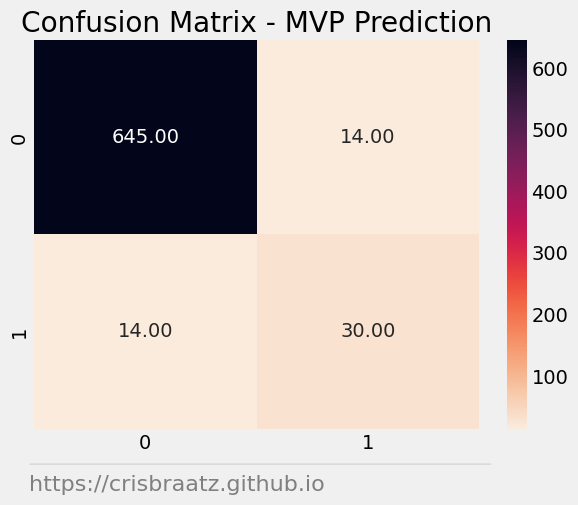

In [ ]:
matplotlib.pyplot.title('Confusion Matrix - MVP Prediction')
seaborn.heatmap(confusion_matrix(df_past_predicted['Won MVP'], df_past_predicted['Predicted MVP Winner']), annot = True, fmt = '0.2f', cmap = 'rocket_r')
matplotlib.pyplot.text(x = -0.02, y = 2.16, s = '__________________________________________', fontsize = 16, color = 'grey', horizontalalignment = 'left', alpha = 0.2)
matplotlib.pyplot.text(x = -0.02, y = 2.32, s = 'https://crisbraatz.github.io', fontsize = 16, color = 'grey', horizontalalignment = 'left')
matplotlib.pyplot.show()

In [ ]:
df_current = df_current[(df_current['GS%'] > 0.9) & (df_current['GP%'] > 0.8)]

In [ ]:
x_train, y_train, x_test, y_test = build_features(df_past, df_current)

model.fit(x_train, y_train)

df_current['MVP Odds'] = model.predict_proba(x_test)[:, 1]
df_current['Predicted MVP Rank'] = df_current.groupby('Season')['MVP Odds'].rank(ascending = False, method = 'dense')
df_current['Predicted MVP Winner'] = df_current['Predicted MVP Rank']
df_current['Predicted MVP Winner'].loc[df_current['Predicted MVP Winner'] != 1] = 0

In [ ]:
df_current.sort_values(by = ['Predicted MVP Rank'], ascending = True)[['Player', 'Tm', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%', '3P%', 'FT%', 'WS', 'WS/48', 'Season', 'Rk', 'Overall', 'W/L%', 'MVP Odds']].head(10)

,Player,Tm,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Season,Rk,Overall,W/L%,MVP Odds
21363,Nikola Jokić,DEN,34.6,26.4,12.4,9.0,1.4,0.9,0.583,0.359,0.817,17.0,0.299,2024,2,57-25,0.695122,0.587659
21210,Luka Dončić,DAL,37.5,33.9,9.2,9.8,1.4,0.5,0.487,0.382,0.786,12.0,0.220,2024,6,50-32,0.609756,0.169920
21265,Shai Gilgeous-Alexander,OKC,34.0,30.1,5.5,6.2,2.0,0.9,0.535,0.353,0.874,14.6,0.275,2024,3,57-25,0.695122,0.147089
21073,Giannis Antetokounmpo,MIL,35.2,30.4,11.5,6.5,1.2,1.1,0.611,0.274,0.657,13.2,0.246,2024,8,49-33,0.597561,0.091260
21623,Jayson Tatum,BOS,35.7,26.9,8.1,4.9,1.0,0.6,0.471,0.376,0.833,10.4,0.189,2024,1,64-18,0.780488,0.072524
21153,Jalen Brunson,NYK,35.4,28.7,3.6,6.7,0.9,0.2,0.479,0.401,0.847,11.2,0.198,2024,7,50-32,0.609756,0.034720
21349,LeBron James,LAL,35.3,25.7,7.3,8.3,1.3,0.5,0.540,0.410,0.750,8.5,0.164,2024,13,47-35,0.573171,0.015012
21292,Tyrese Haliburton,IND,32.2,20.1,3.9,10.9,1.2,0.7,0.477,0.364,0.855,9.0,0.195,2024,12,47-35,0.573171,0.014870
21222,Anthony Edwards,MIN,35.1,25.9,5.4,5.1,1.3,0.5,0.461,0.357,0.836,7.5,0.130,2024,4,56-26,0.682927,0.014516
21196,Anthony Davis,LAL,35.5,24.7,12.6,3.5,1.2,2.3,0.556,0.271,0.816,11.8,0.210,2024,13,47-35,0.573171,0.014309
